## COVID X-ray Image Classification with EfficientNet

### Group-05: Md Karim Uddin, Navdeep Kausish, and Namrata Gupta

#### Goal: Predicting Covid using X-ray dataset ​
#### Source: https://www.kaggle.com/datasets/andyczhao/covidx-cxr2/ ​
#### Dataset: 
COVIDx CXR-3 Dataset from COVID-Net Open Source Initiative ​

####  Data Structure​
This dataset contains images of COVID positive and negative chest radiography images. Each line in the train.txt and test.txt have the following format:​
[patient id] [filename] [class] [data source] ​

#### Version:
Update 06/02/2022:​
#### Data size: 14GB 

In [ ]:
# Importing Required Libraries & Data

In [2]:
os.getcwd()

'/scratch/project_2000859/BDA2023/uddinmdk/covidcxr'

In [3]:
#pip install tensorflow

In [4]:
#pip install keras

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, Activation, Dropout
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.applications.imagenet_utils import preprocess_input
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *

2023-04-05 21:15:27.185052: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-05 21:15:27.187433: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-05 21:15:27.229223: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-05 21:15:27.229908: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 21:15:28.418068: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [6]:
#!pip install -U efficientnet


In [7]:
import efficientnet.keras as efn

In [8]:
train_txt = pd.read_csv('/scratch/project_2000859/BDA2023/uddinmdk/covidcxr/train.txt', sep=" ", header=None)
train_txt.columns= ["Sl.no","File_Name","Status","Source"]
train_txt.head()

,Sl.no,File_Name,Status,Source
0,5,ARDSSevere.png,negative,cohen
1,25,acute-respiratory-distress-syndrome-ards-1.jpg,negative,cohen
2,26,acute-respiratory-distress-syndrome-ards.jpg,negative,cohen
3,27,ards-secondary-to-tiger-snake-bite.png,negative,cohen
4,28,pneumocystis-pneumonia-2-PA.png,negative,cohen


In [9]:
train_txt.drop(["Sl.no","Source"], axis=1, inplace=True)

In [10]:
test_txt= pd.read_csv('/scratch/project_2000859/BDA2023/uddinmdk/covidcxr/test.txt', sep=" ", header=None)
test_txt.columns= ["Sl.no","File_Name","Status","Source"]
test_txt.head()

,Sl.no,File_Name,Status,Source
0,419639-003251,MIDRC-RICORD-1C-419639-003251-46647-0.png,positive,ricord
1,419639-001464,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive,ricord
2,419639-000918,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive,ricord
3,419639-003318,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive,ricord
4,419639-001015,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive,ricord


In [11]:
test_txt.drop(["Sl.no","Source"], axis=1, inplace=True)

In [12]:
current_dir=os.getcwd()
current_dir

'/scratch/project_2000859/BDA2023/uddinmdk/covidcxr'

In [13]:
test_dest_pth= current_dir + '/test/'
test_txt['File_Name'] = test_dest_pth + test_txt['File_Name']

In [14]:
test_txt

,File_Name,Status
0,/scratch/project_2000859/BDA2023/uddinmdk/covi...,positive
1,/scratch/project_2000859/BDA2023/uddinmdk/covi...,positive
2,/scratch/project_2000859/BDA2023/uddinmdk/covi...,positive
3,/scratch/project_2000859/BDA2023/uddinmdk/covi...,positive
4,/scratch/project_2000859/BDA2023/uddinmdk/covi...,positive
...,...,...
395,/scratch/project_2000859/BDA2023/uddinmdk/covi...,negative
396,/scratch/project_2000859/BDA2023/uddinmdk/covi...,negative
397,/scratch/project_2000859/BDA2023/uddinmdk/covi...,negative
398,/scratch/project_2000859/BDA2023/uddinmdk/covi...,negative


In [15]:
dest_pth= current_dir + '/train/'
train_txt['File_Name'] = dest_pth+train_txt['File_Name']

In [16]:
train_txt['Status'].value_counts()

positive    15994
negative    13992
Name: Status, dtype: int64

In [17]:
neg = train_txt.Status[train_txt.Status.eq("negative")].sample(2158).index
pos = train_txt.Status[train_txt.Status.eq("positive")].sample(2158).index 

train_txt = train_txt.loc[neg.union(pos)]

In [18]:
train_txt.shape

(4316, 2)

### Model Training

In [19]:
train_df, valid_df=train_test_split(train_txt, test_size=0.2, stratify=train_txt["Status"], random_state=123)

In [20]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

In [21]:
train_df

,File_Name,Status
3241,/scratch/project_2000859/BDA2023/uddinmdk/covi...,negative
14295,/scratch/project_2000859/BDA2023/uddinmdk/covi...,negative
7059,/scratch/project_2000859/BDA2023/uddinmdk/covi...,negative
16058,/scratch/project_2000859/BDA2023/uddinmdk/covi...,positive
6131,/scratch/project_2000859/BDA2023/uddinmdk/covi...,negative
...,...,...
9238,/scratch/project_2000859/BDA2023/uddinmdk/covi...,negative
10574,/scratch/project_2000859/BDA2023/uddinmdk/covi...,negative
17675,/scratch/project_2000859/BDA2023/uddinmdk/covi...,positive
20907,/scratch/project_2000859/BDA2023/uddinmdk/covi...,positive


In [22]:
train_df.iloc[0,0]

'/scratch/project_2000859/BDA2023/uddinmdk/covidcxr/train/35c9b827-764f-4911-9630-7fd4a9de1ada.png'

In [23]:
valid_df

,File_Name,Status
10372,/scratch/project_2000859/BDA2023/uddinmdk/covi...,negative
9341,/scratch/project_2000859/BDA2023/uddinmdk/covi...,negative
12429,/scratch/project_2000859/BDA2023/uddinmdk/covi...,negative
25926,/scratch/project_2000859/BDA2023/uddinmdk/covi...,positive
12205,/scratch/project_2000859/BDA2023/uddinmdk/covi...,negative
...,...,...
27703,/scratch/project_2000859/BDA2023/uddinmdk/covi...,positive
28056,/scratch/project_2000859/BDA2023/uddinmdk/covi...,positive
26192,/scratch/project_2000859/BDA2023/uddinmdk/covi...,positive
20305,/scratch/project_2000859/BDA2023/uddinmdk/covi...,positive


In [24]:
import os
print( os.path.abspath("valid_df"))

/scratch/project_2000859/BDA2023/uddinmdk/covidcxr/valid_df


In [25]:
#directory — (str)Path to the directory which contains all the images.
#set this to None if your x_col contains absolute_paths pointing to each image files instead of just filenames.

train_generator=datagen.flow_from_dataframe(
dataframe=train_df,
directory=None,
x_col="File_Name",
y_col="Status",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(256,256))

valid_generator=datagen.flow_from_dataframe(
dataframe=valid_df,
directory=None,
x_col="File_Name",
y_col="Status",
subset="validation",
batch_size=10,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(256,256))

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
dataframe=test_txt,
directory=None,
x_col="File_Name",
y_col="Status",
batch_size=32,
seed=42,
shuffle=False,
class_mode="binary",
target_size=(256,256))

Found 2589 validated image filenames belonging to 2 classes.
Found 216 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.


In [26]:
base_model = efn.EfficientNetB0(input_shape = (256, 256, 3), include_top = False, weights = 'imagenet')

2023-04-05 21:16:29.575754: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [27]:
for layer in base_model.layers:
    layer.trainable = False

In [28]:
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid")(x)
model_final = Model(base_model.input,predictions)

In [29]:
model_final.compile('rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

In [30]:
eff_history = model_final.fit_generator(train_generator, validation_data = valid_generator, steps_per_epoch = 50, epochs = 4)

Epoch 1/4


2023-04-05 21:16:32.766440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


50/50 [==============================] - ETA: 0s - loss: 9.0563 - accuracy: 0.8353

2023-04-05 21:17:32.285541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


50/50 [==============================] - 69s 1s/step - loss: 9.0563 - accuracy: 0.8353 - val_loss: 3.8451 - val_accuracy: 0.8102
Epoch 2/4
50/50 [==============================] - 35s 705ms/step - loss: 1.6505 - accuracy: 0.8950 - val_loss: 0.7025 - val_accuracy: 0.9167
Epoch 3/4
50/50 [==============================] - 27s 526ms/step - loss: 0.5981 - accuracy: 0.9169 - val_loss: 0.3284 - val_accuracy: 0.9259
Epoch 4/4
50/50 [==============================] - 23s 455ms/step - loss: 0.4817 - accuracy: 0.9274 - val_loss: 0.2836 - val_accuracy: 0.9444


### Model Validation & Prediction

In [31]:
model_final.evaluate_generator(generator=valid_generator,steps=10)

2023-04-05 21:19:07.062362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


[0.29366356134414673, 0.9700000286102295]

In [32]:
valid_df

,File_Name,Status
10372,/scratch/project_2000859/BDA2023/uddinmdk/covi...,negative
9341,/scratch/project_2000859/BDA2023/uddinmdk/covi...,negative
12429,/scratch/project_2000859/BDA2023/uddinmdk/covi...,negative
25926,/scratch/project_2000859/BDA2023/uddinmdk/covi...,positive
12205,/scratch/project_2000859/BDA2023/uddinmdk/covi...,negative
...,...,...
27703,/scratch/project_2000859/BDA2023/uddinmdk/covi...,positive
28056,/scratch/project_2000859/BDA2023/uddinmdk/covi...,positive
26192,/scratch/project_2000859/BDA2023/uddinmdk/covi...,positive
20305,/scratch/project_2000859/BDA2023/uddinmdk/covi...,positive


In [33]:
model_final.evaluate_generator(generator=test_generator,steps=10)

2023-04-05 21:19:10.336367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


[0.24996714293956757, 0.949999988079071]

In [34]:
pred=model_final.predict_generator(test_generator)

2023-04-05 21:19:24.490264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


In [35]:
len(pred)

400

In [36]:
# Prediction for Test Data
preds=pred.round(decimals=0)
for p in preds:
    print (p)

[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[0.]


In [37]:
test_txt['Status'].value_counts()

positive    200
negative    200
Name: Status, dtype: int64

### Plotting Model Loss & Accuracy

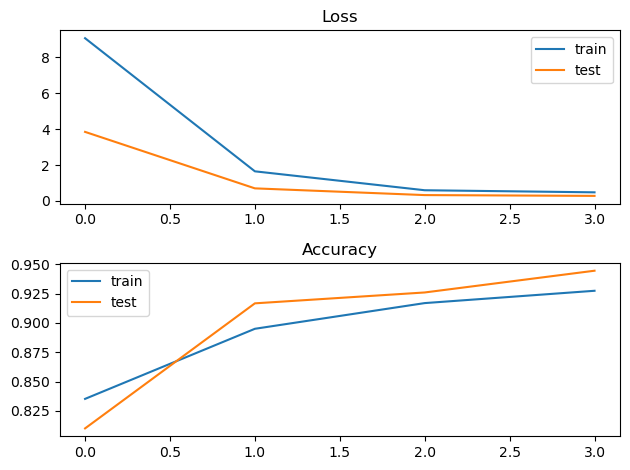

In [38]:
from matplotlib import pyplot
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(eff_history.history['loss'], label='train')
pyplot.plot(eff_history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(eff_history.history['accuracy'], label='train')
pyplot.plot(eff_history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.tight_layout()
pyplot.show()

### Model Performance Analysis

In [39]:
test_generator.class_indices

{'negative': 0, 'positive': 1}

In [40]:
test_txt['Status'][test_txt['Status']=='positive']=1.0
test_txt['Status'][test_txt['Status']=='negative']=0.0

In [41]:
test_txt['Status'].astype('float')

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
395    0.0
396    0.0
397    0.0
398    0.0
399    0.0
Name: Status, Length: 400, dtype: float64

In [42]:
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, preds))
mat = confusion_matrix(test_generator.classes, preds)
print('Classification Report')
target_names = ['Negative', 'Positive']
print(classification_report(test_generator.classes, preds, target_names=target_names))

Confusion Matrix
[[184  16]
 [ 10 190]]
Classification Report
              precision    recall  f1-score   support

    Negative       0.95      0.92      0.93       200
    Positive       0.92      0.95      0.94       200

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.93       400
weighted avg       0.94      0.94      0.93       400



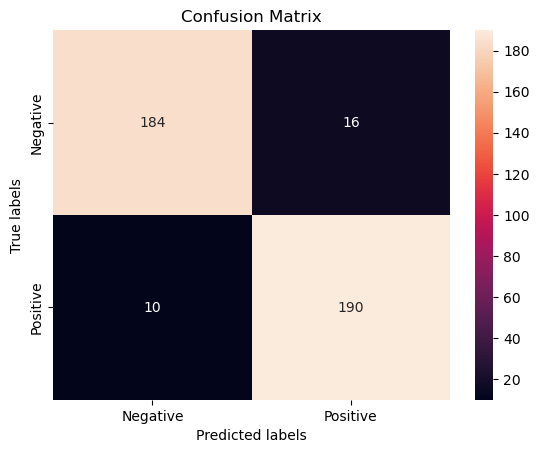

In [43]:
ax= plt.subplot()
sns.heatmap(mat, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Negative', 'Positive']); ax.yaxis.set_ticklabels(['Negative', 'Positive']);

### Checking Model Predictions

In [44]:
# Picking out a Positive Test Sample
print(test_txt['File_Name'][112])
test_txt['Status'][112]

/scratch/project_2000859/BDA2023/uddinmdk/covidcxr/test/MIDRC-RICORD-1C-419639-000025-39552-1.png


1.0

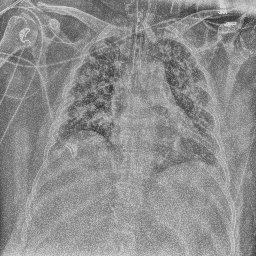

In [45]:
import numpy as np
from keras.preprocessing import image
#image_path = current_dir + '/project_xray/test/MIDRC-RICORD-1C-419639-000025-39552-1.png'
test_image= tf.keras.utils.load_img(test_txt['File_Name'][112]
                                    ,target_size =(256,256))
test_image

In [46]:
preds[112]

array([1.], dtype=float32)

#### The Test Image is a Positive Sample & Model Result also indicates that the sample is Positive

### Validation of Predictions

In [47]:
# We are taking a sample of 4 Positive & Negative Images
# We will look at the predictions generated for the above images

pos_imgs=[]
neg_imgs=[]
pos_imgs.append(test_txt['File_Name'][60])
pos_imgs.append(test_txt['File_Name'][79])
pos_imgs.append(test_txt['File_Name'][138])
pos_imgs.append(test_txt['File_Name'][141])
neg_imgs.append(test_txt['File_Name'][287])
neg_imgs.append(test_txt['File_Name'][252])
neg_imgs.append(test_txt['File_Name'][253])
neg_imgs.append(test_txt['File_Name'][243])
imgs =[]
for i in pos_imgs:
    imgs.append(i)
for i in neg_imgs:
    imgs.append(i)

In [48]:
# Model generated predictions for above Images
preds[[60,79,138,141,287,252,253,243]]

array([[1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

#### It is found that for randomly picked 4 Positive & 4 Negative Images. Model Prediction Output has classified the samples correctly

<Figure size 640x480 with 0 Axes>

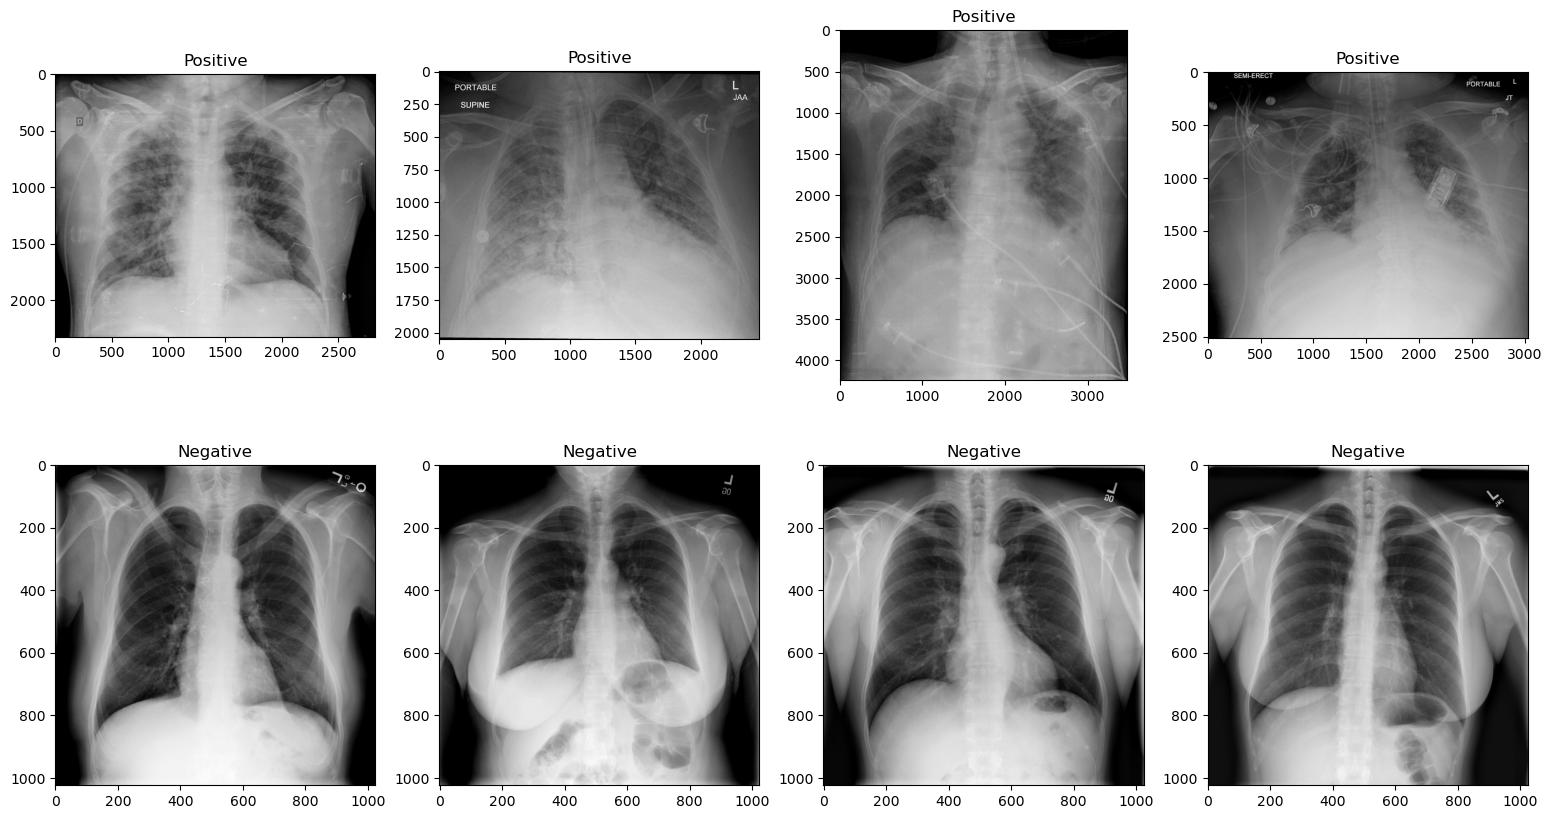

In [49]:
# Visualization of the above selected Images
plt.figure()
images=[]

#subplot(r,c) provide the no. of rows and columns

for i in range(len(imgs)):
    it_image = plt.imread(imgs[i]) 
    images.append(it_image)
f, axarr = plt.subplots(2,4,figsize=(19,10)) 
axarr[0,0].imshow(images[0],cmap='gray')
axarr[0,1].imshow(images[1],cmap='gray')
axarr[0,2].imshow(images[2],cmap='gray')
axarr[0,3].imshow(images[3],cmap='gray')
axarr[1,0].imshow(images[4],cmap='gray')
axarr[1,1].imshow(images[5],cmap='gray')
axarr[1,2].imshow(images[6],cmap='gray')
axarr[1,3].imshow(images[7],cmap='gray')
axarr[0,0].title.set_text('Positive')
axarr[0,1].title.set_text('Positive')
axarr[0,2].title.set_text('Positive')
axarr[0,3].title.set_text('Positive')
axarr[1,0].title.set_text('Negative')
axarr[1,1].title.set_text('Negative')
axarr[1,2].title.set_text('Negative')
axarr[1,3].title.set_text('Negative')
plt.show()